In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9,9)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
torch.manual_seed(0)
import scipy.signal as sp

![simpleresnet.png](simpleresnet.png)

This exercies uses a simple implementation of a deep neural network to explore the vanishing gradient problem

In [2]:
# Choose an activation function
activation = torch.tanh

# Choose a number of iterations
n = 500


Text(0, 0.5, 'Weight Gradients')

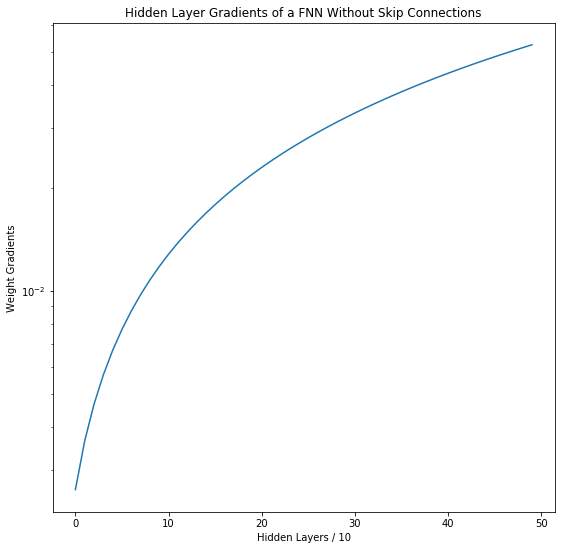

In [88]:
# Store the feed-forward steps
w_list = []
z_list = []
a_list = []

# Make up some data
z_obs = torch.tensor([1.0])

# Initial value
x = torch.randn((1,),requires_grad=True)
z_prev = x

# Loop over a number of hidden layers
for i in range(n):
    # New weight
    w_i = torch.tensor([1.0],requires_grad=True)

    # Linear transform
    a_i = z_prev*w_i

    # Activation
    zprime_i = activation(a_i)

    #TODO: replace the line below with one that would add a skip connection
    z_i = zprime_i
    # Store forward model stuff
    w_list.append(w_i)
    z_list.append(z_prev)
 

    # output of layer i becomes input for layer i+1
    z_prev = z_i

# Objective function
L = torch.sqrt((z_i - z_obs)**2)

# Reverse-mode AD
L.backward()

# Print each weight's gradient
w_grad = []

#w_list.reverse()
for i in range(len(w_list)):
    grad = torch.abs(w_list[i].grad).tolist()[0]
    w_grad.append(grad)
    
plt.semilogy(w_grad[::10])
plt.title('Hidden Layer Gradients of a FNN Without Skip Connections')
plt.xlabel('Hidden Layers / 10')
plt.ylabel('Weight Gradients')

Text(0, 0.5, 'Weight Gradients')

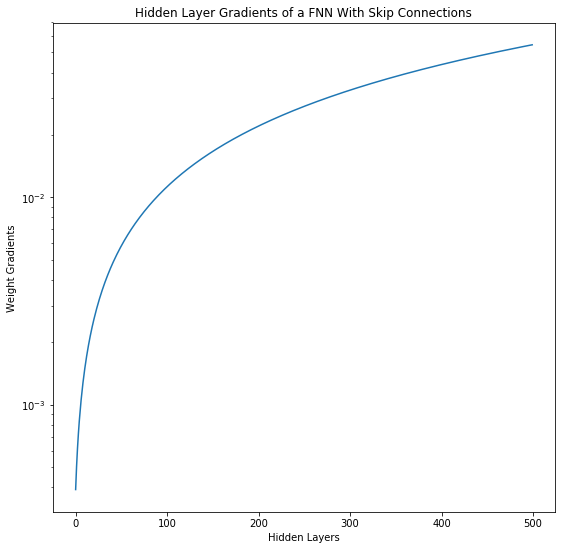

In [86]:
# Store the feed-forward steps
w_list = []
z_list = []
a_list = []

# Make up some data
z_obs = torch.randn((1,))
# Initial value
x = torch.randn((1,),requires_grad=True)
z_prev = x
# Loop over a number of hidden layers
for i in range(1,n+1):
    # New weight
    w_i = torch.tensor([1.],requires_grad=True)
   
    # Linear transform
    a_i = w_i*z_prev 

    # Activation
    zprime_i = activation(a_i) 

    # TODO: replace the line below with one that would add a skip connection
    
    # use the .add(tensor) method
    
    # think about how we would skip multiple layers using MULTIPLE skip lengths in this instance (hint, use branching and the modulus operator)
    
    # We found the results to be VERY non-linear
   
    z_i = zprime_i
    
    # Store forward model stuff
    w_list.append(w_i)
    z_list.append(z_prev)
    # output of layer i becomes input for layer i+1
    z_prev = z_i

# Objective function
L = torch.sqrt((z_i - z_obs)**2)

# Reverse-mode AD
L.backward()

# Print each weight's gradient
w_grad = []

#w_list.reverse()
for i in range(len(w_list)):
    grad = torch.abs(w_list[i].grad).tolist()[0]
    w_grad.append(grad)

#w_grad = sp.savgol_filter(w_grad,5,3)
plt.semilogy(w_grad)
plt.title('Hidden Layer Gradients of a FNN With Skip Connections')
plt.xlabel('Hidden Layers')
plt.ylabel('Weight Gradients')


Now that we have seen how implementing skip connections seemingly solve the problem of vanishing gradients, we've learned all we can from the paper, lets look at some applications

------------

Below is a simple example of an image processing problem where vanishing gradient becomes an issue (no need to show it this time)

For training and testing data I generated random images for a training and test set. If the small problems are too easy feel free to increase the size of the datasets to make for more challenging problems

After you get done with the conceptual questions below, feel free to change the architecture of the below net. Make 3 changes to the architecture, record the loss differnece after 100 iterations, and come up with a justification for that difference in loss

In [6]:
# basic net class
class Net(nn.Module):
    def __init__(self, num_input_images, num_layers):
        
        # batch size is needed to configure 
        self.num_input_images = num_input_images
        self.num_layers = num_layers
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding = 1)
        self.linearization = nn.Linear(5*26*26,10)        
        self.convout = nn.Conv2d(1, 5, 3)
    def forward(self, x):
        zprev = x
        # convolution
        for i in range(self.num_layers):
            x = self.conv1(x)
            # activation
            x = F.relu(x)
        x = self.convout(x)
        # outputed images needed to be flattened for a linear layer
        x = x.view(self.num_input_images, 5*26*26)
        # find linear patterns in non-linear data
        x = self.linearization(x)
        return x    

In [7]:
num_input_images = 100
num_epochs = 1500
num_classes = 10
num_layers = 5
# Everyone's playing with the same seed, same data
torch.manual_seed(0)
rand_train_data = torch.randn(num_input_images, 1, 28, 28)
rand_train_labels = torch.LongTensor(num_input_images).random_(0, 10)
rand_test_data = torch.randn(num_input_images, 1, 28, 28)
rand_test_labels = torch.LongTensor(num_input_images).random_(0, 10)

learning_rate = 1e-3  # The speed of convergence

# net class
net = Net(num_input_images, num_layers)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [8]:
net = train_model(100) #train the model for a hundred epochs

correct = 0
total = 0        

for d,t in test_loader:
    # Zero out the optimizer's gradient buffer
    optimizer.zero_grad()
    # Make a prediction based on the model
    outputs = net(d)
    _, predicted = torch.max(outputs.data, 1)
    correct += len(predicted[predicted==t[:,0]])
    total += len(predicted.flatten())
                     
print('Test Accuracy = ', correct/total*100)

2.3216419219970703
2.3435585498809814
2.3426177501678467
2.331850051879883
2.3246710300445557
2.324899911880493
2.3305063247680664
2.3397741317749023
2.352842092514038
2.369727611541748
2.388934373855591
2.408127546310425
2.425434112548828
2.440176486968994
2.452862501144409
2.464570999145508
2.476323127746582
2.4887278079986572
2.5019614696502686
2.515907049179077


**Questions**

1. What is the vanishing gradient problem, and what is its primary cause?

2. What are 4 limitations to optimizing a deep convolutional neural network?

3. In terms of how a given block of a network is "fitted", what is the key difference between using skip connections and traditional blocks?

4. In the context of model hyper-parameters, what additional parameters is added in the res-net implementation?

5. How do skip connections resolve the "vanishing gradient" problem? (Open Ended)

6. Give an appropriate anology for how kernels are used to extract features from images (i.e. sanding wood)

7. Was this a good paper when it was released? Is it a good paper now? What has changed between now and it's initial release point? What other methods are there of solving the vanishing gradient problem? (Open Ended)
